## Introduction to Geospatial Analysis Using python libraries
A brief tutorial on making maps and doing geospatial analysis using python libraries.<br> Greenpeace Investigations Skillshare, June 2019, Manila.

### Table of Contents<a id='toc'></a>

1. [Reading a shapefile with geopandas](#geopandas)<br>
2. [Fancier maps with cartopy](#cartopy)<br>
3. [Using other data to make a choropleth](#choropleth)<br>
4. [Geospatial analysis with shapely](#shapely)
5. [Next Steps](#next)

#### Installation
The libraries used in this tutorial can be installed using package managers such as Canopy or Anaconda. The one exception is that geopandas is not currently availabe in Canopy (although its dependencies are) and should be installed by hand (for example, using 'pip'). More info available <a href="http://geopandas.org/install.html">here</a>.

### 1. Reading a shapefile with geopandas<a id='geopandas'></a>

The first tutorial walked us through the pandas library for data analysis. For this tutorial we will use <a href="http://geopandas.org">geopandas</a> -- an extension of pandas specifically designed for geospatial information. Geopandas is built on top of open-source geospatial libraries <a href="https://trac.osgeo.org/geos/">GEOS</a>, <a href="https://gdal.org/">GDAL</a>, and <a href="https://proj.org/">PROJ</a>, and their python interfaces (<a href="https://pypi.org/project/Shapely/">shapely</a>, <a href="https://pypi.org/project/Fiona/">fiona</a>, and <a href="https://pypi.org/project/pyproj/">pyproj</a>, respectively) as well as pandas. For starters, we will open a shapefile using geopandas.

In [1]:
# first we import the libraries
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gp
import shapely

A shapefile is a common format for packaging geospatial information. They usually come as zip files, and when you unzip them, there are 5-6 separate files inside that get dumped into a folder. The main one we will be looking at for this is the .shp file, which we will read using geopandas into a data structure called a GeoDataFrame. This is highly analogous to the regular pandas DataFrame we talked about in the earlier session, but with a dedicated column for geometry information.

We will be using a shapefile describing all the counties in the U.S., downloaded from the U.S. Census Bureau. A county is a small subdivision of a U.S. state (apologies for the U.S.-centric example!).

In [6]:
# read Census CONUS shapefile into GeoDataFrame
conus = gp.read_file('./cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
conus.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.762442, -87.868184 32...."


This lets us look inside the shapefile, and we can see that each database entry has a final column entitled geometry. This describes the actual geographic shape we wish to display. The entries in this column describe what type of shape it is, some options include:
<ul><li>POINT (made up of x and y coordinates)
<li>LINESTRING (a series of connected POINTs)
<li>POLYGON (a series of connected POINTs that ends where it starts, defining an enclosed 2D area)
</ul>

The values of the x and y values depend on the coordinate system being used. In this case, the values are just ordinary longitude and latitude (using the NAD83 reference system), but other shapefile data may be defined in terms of different projections. One useful tool for figuring out which projection your shapefile is using is <a href="http://prj2epsg.org/search">this website</a>, which takes the associated .prj file and tells you the projection.

In this case, each entry in the GeoDataFrame is a U.S. county. The fields STATEFP and COUNTYFP are standardized codes developed by the U.S. Census telling us which state and county is referred to; the common name is found in the NAME field. The POLYGON geometry defines the boundary for each county. Ideally the source where you got the shapefile will define all these fields for you. 

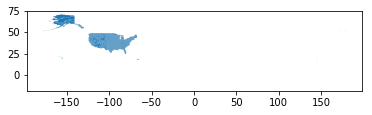

In [7]:
# plot routine gives us a quick look at the shapefile
# NOTE: need to install descartes in order to plot polygons in geopandas
conus.plot()

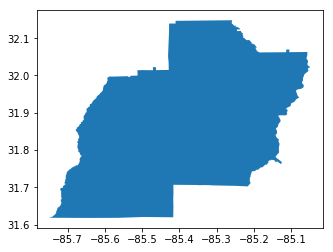

In [8]:
# we can even pick out one row from the GeoDataFrame and plot it (this is Barbour County, Alabama)
conus.iloc[:1].plot()

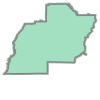

In [9]:
# jupyter will even do a quick rendering of the geometry for you
conus.iloc[0].geometry

In [10]:
# you can look and see what coordinate reference system the shapefile thinks it is using (in this case none)
conus.crs

{}

### 2. Fancier maps with cartopy<a id='cartopy'></a>

The geopandas "plot" routine is easy to use, but not very versatile. If we want to make more interesting plots with more elements in them, it is better to import some additional map-making tools. In python there are two main options for this (<a href="https://scitools.org.uk/cartopy/docs/v0.13/index.html">cartopy</a> and <a href="https://matplotlib.org/basemap/">basemap</a>) and we'll be working with cartopy for what follows.

In [11]:
# first we need to import the cartopy library, and some specific tools
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.feature import ShapelyFeature

Next we need to figure out which map projection we should use to take our round globe and flatten it to the computer screen. The choice of projection depends a lot on what you want your map to do well and look like. There is a <a href="https://scitools.org.uk/cartopy/docs/v0.13/crs/projections.html">list of supported projections</a> on the cartopy website. For this map we will use the Albers Equal Area projection.

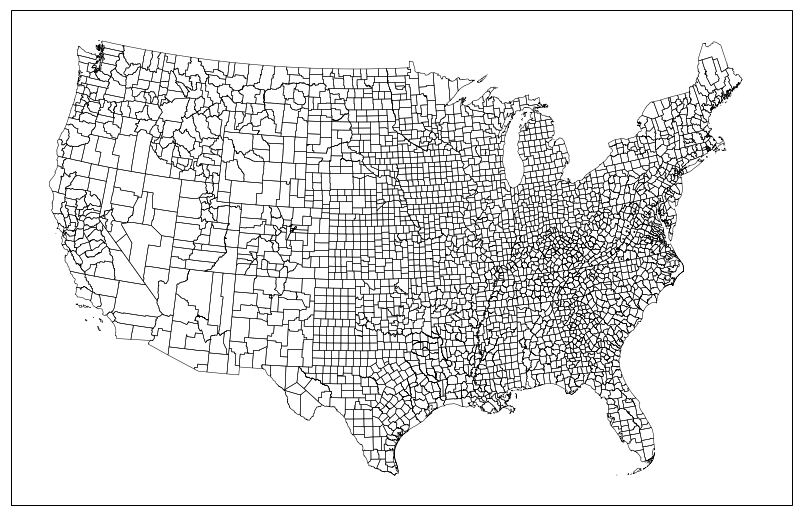

In [12]:
# set the figure size in matplotlib
fig, ax = plt.subplots(figsize=(14, 10))

# set the projection using cartopy ccrs, and return an axis object
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))

# set the extent of the axis object, in this case we zoom in on the Lower 48 states of the U.S.
ax.set_extent([-122,-72,22,50])

# then we loop over every shape in the shapefile
# for each geometry we make a ShapelyFeature object and then add it to the map
for poly in conus.geometry:
    shape = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor='none')
#    shape = ShapelyFeature([poly], ccrs.epsg(4269), edgecolor='black', facecolor='none')
    ax.add_feature(shape, linewidth=0.5)

# NOTE: ShapelyFeature seems to require an iterable object, so poly goes inside a list of one
# NOTE: ccrs=PlateCarree works fine for the purposes of this shapefile and thematic map,
#       but other data or map uses may need to use something different here

Now that we have this handy recipe for displaying a shapefile, we can do funstuff with it, like make a map of every county whose name starts with "C." 

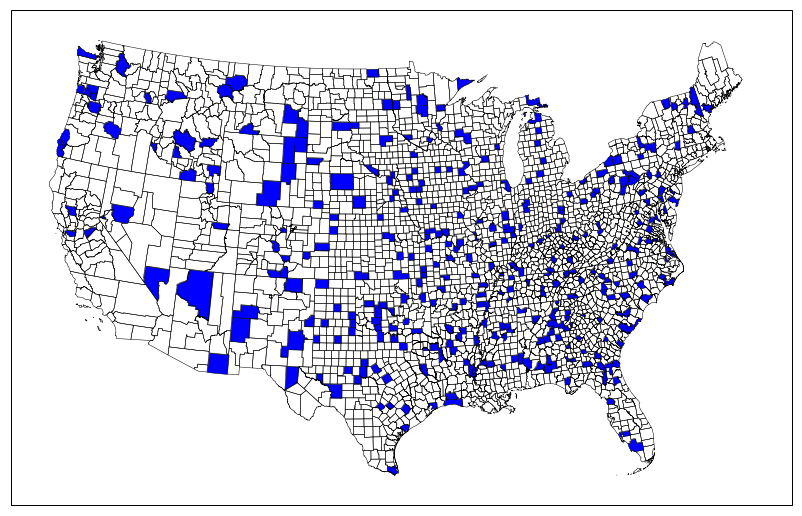

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))
ax.set_extent([-122,-72,22,50])

# then we loop over every shape in the shapefile
for name, poly in zip(conus['NAME'], conus.geometry):
    if name[0]=='C':
        color='blue'
    else:
        color='none'
    shape = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor=color)
    ax.add_feature(shape, linewidth=0.5)

### 3. Using other data to make a choropleth<a id='choropleth'></a>

A <a href="https://en.wikipedia.org/wiki/Choropleth_map">choropleth</a> is a very fancy word for a map where areas are colored according to the statistical measurement being shown. We combine our county-level map recipe with government data on oil and gas production to create a map of oil production in the U.S. (data source: <a href="https://www.ers.usda.gov/data-products/county-level-oil-and-gas-production-in-the-us/">USDA Economic Research Service</a>).

NOTE: this is a simplified version of this analysis: <a href="https://www.greenpeace.org/usa/research/meet-the-fourteen-house-members-who-pump-most-of-our-oil/">Meet the Fourteen House Members Who Pump Most of Our Oil</a>, full code available on <a href="https://github.com/quinn43/oil-production-maps">github</a>.

In [14]:
import pandas as pd
import matplotlib as mpl

In [15]:
# let's read in a database of oil and gas production by county
og_conus_0011 = pd.read_excel('./ERS_oilgascounty.xls')
og_conus_0011.head(2)

,FIPS,geoid,Stabr,County_Name,Rural_Urban_Continuum_Code_2013,Urban_Influence_2013,Metro_Nonmetro_2013,Metro_Micro_Noncore_2013,oil2000,oil2001,...,gas2005,gas2006,gas2007,gas2008,gas2009,gas2010,gas2011,oil_change_group,gas_change_group,oil_gas_change_group
0,1001,1001,AL,Autauga County,2,2,1,2,0,0,...,0,0,0,0,0,0,0,Status Quo,Status Quo,Status Quo
1,1003,1003,AL,Baldwin County,3,2,1,2,138072,134666,...,84536875,83951640,82876786,78547145,68525628,63069025,51041072,Status Quo,H_Decline,H_Decline


The first column, labeled FIPS, is a standard numerical code that describes U.S. counties, and is constructed out of the very same state and county codes used in the shapefile above (fips = state + county). So we can use this code to merge our two datasets and make a map combining info from both.

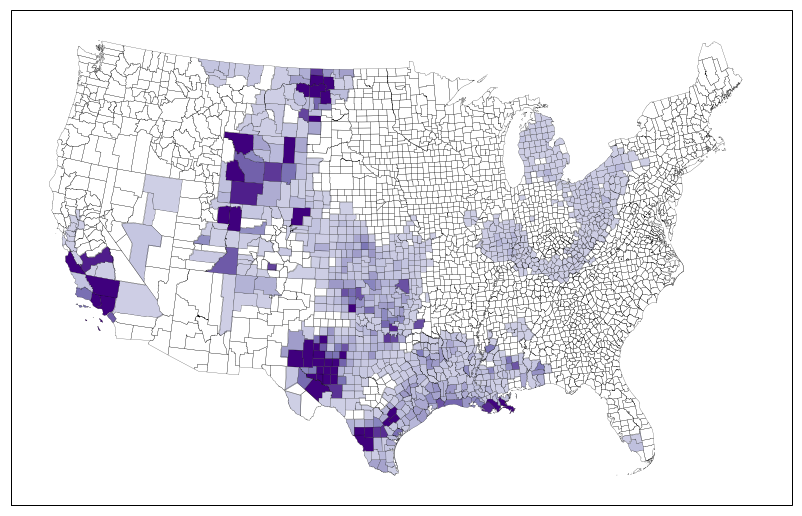

In [16]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))
ax.set_extent([-122,-72,22,50])

# let's set a color map
cmap = mpl.cm.get_cmap('Purples')
oilmax = 10000000.0

# so for each shape in the shapefile, we construct its FIPS code
# we then use that code to lookup that county in the oil/gas database
for statefp, countyfp, name, poly in zip(conus['STATEFP'], conus['COUNTYFP'], conus['NAME'], conus.geometry):
    fips = int(statefp)*1000 + int(countyfp)  # FIPS code for the county
    
    rows = og_conus_0011[og_conus_0011['FIPS']==fips]   # returns all rows matching that FIPS code
    if len(rows)==1:   # test to make sure there is exactly one row with that FIPS code (avoids data errors)
        oil2011 = rows['oil2011'].iloc[0]
        if oil2011==0.0:
            color = 'none'
        else:
            color = cmap(0.3 + oil2011/oilmax)

    shape = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor=color)
    ax.add_feature(shape, linewidth=0.2)

### 4. Geospatial analysis with shapely<a id='shapely'></a>

The shapely geometry library allows us to do spatial analysis with POINTS, LINES, and POLYGONS. We can do things like create buffers, test for intersections, combine objects, etc. We build out an example of how to do this by looking at the track of Hurricane Katrina (This is adapted from this cartopy <a href="https://scitools.org.uk/cartopy/docs/v0.13/examples/hurricane_katrina.html">example</a>).

In [17]:
import shapely.geometry as sgeom

First, we input some data describing the hurricane track in longitude and latitude, and create a shapely geometry object using the LineString constructor. As usual, jupyter lets us take a quick peek at the shape.

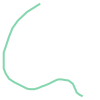

In [18]:
lons = [-75.1, -75.7, -76.2, -76.5, -76.9, -77.7, -78.4, -79.0, -79.6, -80.1, -80.3, 
        -81.3, -82.0, -82.6, -83.3, -84.0, -84.7, -85.3, -85.9, -86.7, -87.7, -88.6, 
        -89.2, -89.6, -89.6, -89.6, -89.6, -89.6, -89.1, -88.6, -88.0, -87.0, -85.3, -82.9]

lats = [23.1, 23.4, 23.8, 24.5, 25.4, 26.0, 26.1, 26.2, 26.2, 26.0, 25.9, 25.4, 25.1, 
        24.9, 24.6, 24.4, 24.4, 24.5, 24.8, 25.2, 25.7, 26.3, 27.2, 28.2, 29.3, 29.5, 
        30.2, 31.1, 32.6, 34.1, 35.6, 37.0, 38.6, 40.1]

track = sgeom.LineString(list(zip(lons, lats)))  # create a Shapely object from the raw numbers
track

Let's add this to our map, and set the color of each county depending on whether it intersects the hurricane track or not. To do this we call the 'intersects' subroutine from each county polygon.

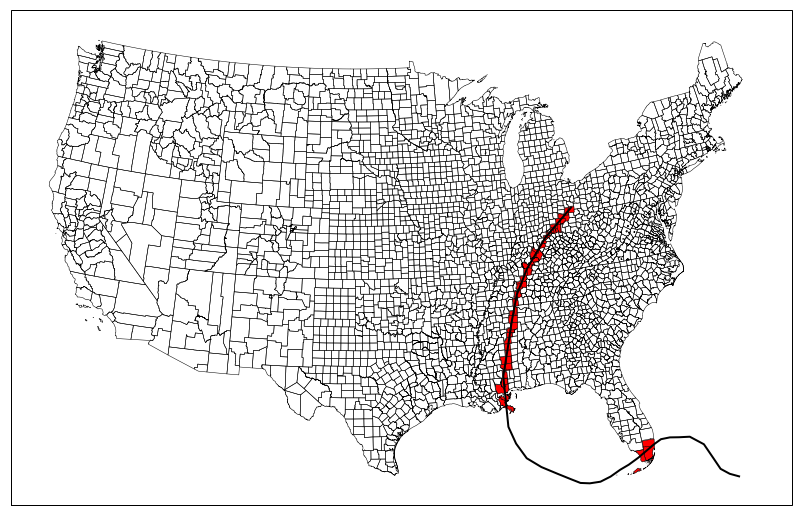

In [19]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))
ax.set_extent([-122,-72,22,50])

for poly in conus.geometry:
    if poly.intersects(track):
        color = 'red'
    else:
        color = 'none'
    shape = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor=color)
    ax.add_feature(shape, linewidth=0.5)

ax.add_geometries([track], ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=2.0)


Now of course, hurricanes are pretty big, so even counties that were not a "direct hit" will have suffered damage. So we can increase the thickness of the track line, by using the "buffer" routine.

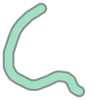

In [20]:
track_buffer = track.buffer(1)  # native unit is degrees
track_buffer

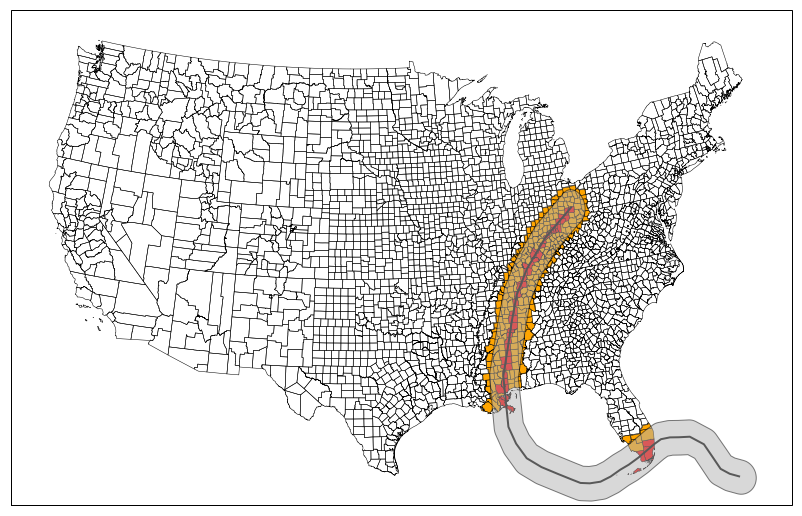

In [21]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))
ax.set_extent([-122,-72,22,50])

for poly in conus.geometry:
    if poly.intersects(track):
        color = 'red'
    elif poly.intersects(track_buffer):
        color = 'orange'
    else:
        color = 'none'
    shape = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor=color)
    ax.add_feature(shape, linewidth=0.5)

ax.add_geometries([track], ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=2.0)
ax.add_geometries([track_buffer], ccrs.PlateCarree(), edgecolor='k', facecolor='0.7', linewidth=1.0, alpha=0.5)


### 5. Next Steps<a id='next'></a>

This tutorial is naturally a very quick introduction to geospatial analysis in python and there is a lot more that can be done. Hopefully this will be useful in terms of getting started. I hope to build out some more examples in the future, potentially including:
<ul>

<li><b>Working with projections:</b> I glossed over this topic here, but <a href="http://geopandas.org/projections.html">geopandas and pyproj have tools</a> for dealing with various different map projections (a complicated topic!)
<li><b>Making prettier maps in cartopy:</b> The maps we made here are very simple and basic, but there is <a href="https://scitools.org.uk/cartopy/docs/latest/gallery/index.html">more that cartopy can do</a>, including adding basemap images, data from <a href="https://www.naturalearthdata.com/">Natural Earth</a>, contours, arrows, etc. 

<li><b>Interactive web maps:</b> By popular demand! This <a href="https://blog.prototypr.io/interactive-maps-with-python-part-1-aa1563dbe5a9">article</a> has a good intro to using <a href="https://python-visualization.github.io/folium/">folium</a> and other tools to create interactive web maps in python. 

<li><b>Satellite data:</b> There is a python library called <a href="https://rasterio.readthedocs.io/en/stable/">rasterio</a> that lets you display and work with satellite raster images, which seems like a critical tool in the GP investigations toolkit worth building out further.

<li><b>Colaboratory:</b> <a href="https://colab.research.google.com">Google Drive</a> now has the ability to run and share jupyter notebooks, which could be a very useful tool for the investigations community!

</ul>

#### Further Resources and Reading
<ul>
<li>Tutorial: <a href="https://github.com/kjordahl/SciPy-Tutorial-2015">Geospatial Data with Open Source Tools in Python</a> (video lecture <a href="https://www.youtube.com/watch?v=HzPSVwyP2Y0">here</a>)
<li>Tutorial: <a href="https://gist.github.com/jorisvandenbossche/7b30ed43366a85af8626">GeoPandas: the perfect marriage between shapefiles and dataframes</a>
<li>Resources: https://pythongisresources.wordpress.com/
<li>Resources: <a href="http://www.data-analysis-in-python.org/t_gis.html">GIS in Python</a>
<li><a href="https://ocefpaf.github.io/python4oceanographers/blog/2015/08/24/choropleth/">Three ways to make a choropleth</a>
<li><a href="https://github.com/andrea-cuttone/geoplotlib">geoplotlib</a>
<li><a href="http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/">How to make beautiful data visualizations in Python with matplotlib</a>
</ul>